In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import operator

In [2]:
%%time

import cPickle
import praw

threads = cPickle.load(open('all_comments_dict.p', 'rb'))
print len(threads)

100
CPU times: user 1min 30s, sys: 1min 13s, total: 2min 44s
Wall time: 3min 51s


In [3]:
from pprint import pprint
pprint (vars(threads['2rb0pa'][0]))

{'_has_fetched': True,
 '_has_fetched_replies': True,
 '_info_url': u'https://api.reddit.com/api/info/',
 '_replies': [<praw.objects.Comment object at 0x1899cf390>],
 '_submission': <praw.objects.Submission object at 0x189972ad0>,
 '_underscore_names': [u'replies'],
 '_uniq': None,
 'approved_by': None,
 'archived': True,
 'author': Redditor(user_name='finndre'),
 'author_flair_css_class': None,
 'author_flair_text': None,
 'banned_by': None,
 'body': u'Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf',
 'body_html': u'<div class="md"><p>Private prisons with lockup quotas. States are contractually obligated to fill prison beds. wtf</p>\n</div>',
 'controversiality': 0,
 'created': 1420430099.0,
 'created_utc': 1420401299.0,
 'distinguished': None,
 'downs': 0,
 'edited': False,
 'gilded': 0,
 'id': u'cnecm22',
 'json_dict': None,
 'likes': None,
 'link_id': u't3_2rb0pa',
 'mod_reports': [],
 'name': u't1_cnecm22',
 'num_reports': None,
 'p

In [4]:
fields = ['_replies',
          '_submission',
          'author',
          'author_flair_css_class',
          'author_flair_text',
          'banned_by',
          'body',
          'body_html',
          'controversiality',
          'created',
          'created_utc',
          'distinguished',
          'downs',
          'edited',
          'gilded',
          'score',
          'score_hidden',
          'subreddit',
          'ups'
         ]

dlist = []
for thread in threads: 
    for comment in threads[thread]:
        temp_d = {}
        temp_d['thread'] = thread
        for field in fields:
            temp_d[field] = comment.__dict__[field]
        dlist.append(temp_d)

df = pd.DataFrame(dlist)
df.head(5)

,_replies,_submission,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,created_utc,distinguished,downs,edited,gilded,score,score_hidden,subreddit,thread,ups
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,None,None,None,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,None,0,False,0,2485,False,AskReddit,36ih74,2485
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,None,None,None,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,None,0,False,1,4983,False,AskReddit,36ih74,4983
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,None,None,None,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,None,0,False,0,2386,False,AskReddit,36ih74,2386
3,"[That sounds painful., Some people just can't ...",4701 :: What is one sentence that people in yo...,cgrosshans,None,None,None,"""Move off that shallow pocket and greasy crimp...","<div class=""md""><p>&quot;Move off that shallow...",0,1432084937,1432056137,None,0,False,0,3197,False,AskReddit,36ih74,3197
4,[Sounds like a good roller disc. ],4701 :: What is one sentence that people in yo...,rottinguy,None,None,None,The disc is so understable I have to put a rid...,"<div class=""md""><p>The disc is so understable ...",0,1432086084,1432057284,None,0,False,0,1438,False,AskReddit,36ih74,1438


In [5]:
print len(df[df['downs'] != 0])

0


###Author Features

We can also extract features from the username of the author of the comment! 

A **valid** username in Reddit can only have 3-20 characters out of A-Z, a-z, 0-9, underscores (_), and dashes (-). 

The following features are potentially interesting:

1. ```un_length```: Username length
2. ```un_punc```: Username punctuation:
  * 0: no underscores or dashes
  * 1: only one of underscores or dashes
  * 2: both underscores and dashes
3. ```un_case```: Letter cases
  * 0: only lowercase letters
  * 1: only uppercase letters
  * 2: both uppercase and lowercase letters
4. ```un_number```: Ratio of username that is numbers
5. Special usernames:
  * ```un_PM```: "PM_(x)" usernames
  * ```un_bot```: Contains "bot"
6. TO-DO: Profanity in the username

In [6]:
df['un_length'] = df['author'].map(lambda x : len(str(x)))

In [7]:
def un_punc (text):
    total = 0
    if '_' in text: total += 1
    if '-' in text: total += 1
    return total

df['un_punc'] = df['author'].map(lambda x : un_punc(str(x)))

In [8]:
def un_case (text):
    if text.islower(): return 0
    if text.isupper(): return 1
    return 2

df['un_case'] = df['author'].map(lambda x : un_case(str(x)))

In [9]:
def un_number (text):    
    numbers = sum(c.isdigit() for c in text)
    return float(numbers)/float(len(text))

df['un_number'] = df['author'].map(lambda x : un_number(str(x)))

In [10]:
df['un_PM'] = df['author'].map(lambda x : 1 if str(x)[:3] == "PM_" else 0)
df['un_bot'] = df['author'].map(lambda x : 1 if 'bot' in str(x).lower() else 0)

###Analysis of Author Features
**Disclaimer**: Note that the below are all shallow, preliminary observations: in fact, combinations, rather than a single feature observations, will be more telling (which is the purpose of machine learning!). 

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


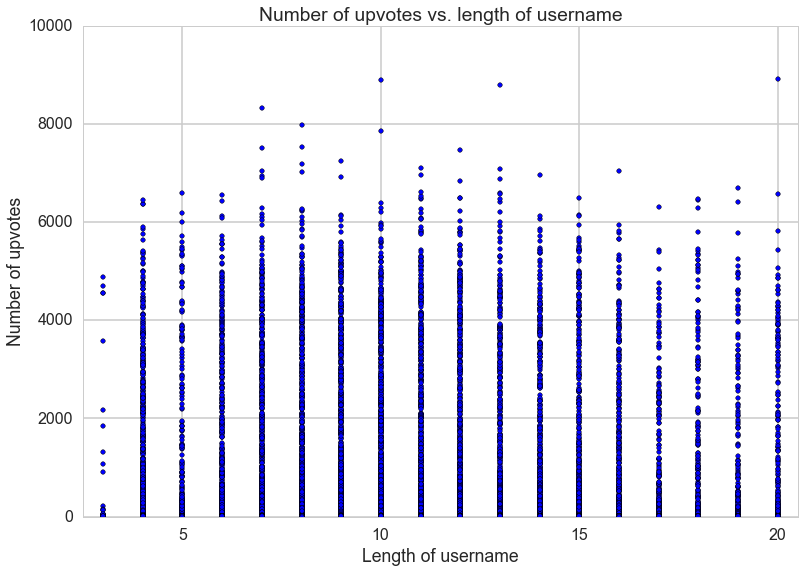

In [11]:
plt.scatter(df['un_length'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([2.5, 20.5])
plt.title('Number of upvotes vs. length of username')
plt.xlabel('Length of username')
plt.ylabel('Number of upvotes')

From the above, there does not seem to be a trend between number of upvotes and length of username.

In [12]:
print "Baseline average # of upvotes:", float(sum(df.ups))/float(len(df))

Baseline average # of upvotes: 80.8764642655


In [13]:
print "Username punctuation averages:"
print "________________________________"
print "# of usernames with no punctuation:", len(df[df['un_punc'] == 0])
print "Average # of upvotes:", float(sum(df[df['un_punc'] == 0].ups))/float(len(df[df['un_punc'] == 0]))
print "________________________________"
print "# of usernames with underscores or dashes:", len(df[df['un_punc'] == 1])
print "Average # of upvotes:", float(sum(df[df['un_punc'] == 1].ups))/float(len(df[df['un_punc'] == 1]))
print "________________________________"
print "# of usernames with both underscores and dashes:", len(df[df['un_punc'] == 2])
print "Average # of upvotes:", float(sum(df[df['un_punc'] == 2].ups))/float(len(df[df['un_punc'] == 2]))

Username punctuation averages:
________________________________
# of usernames with no punctuation: 142246
Average # of upvotes: 79.1228575847
________________________________
# of usernames with underscores or dashes: 22220
Average # of upvotes: 91.9317281728
________________________________
# of usernames with both underscores and dashes: 207
Average # of upvotes: 99.2125603865


Most of the usernames have no punctuation -- however, there is a trend towards more punctuation, more upvotes. Usernames with no punctuation do worse than average.

In [14]:
print "Username case averages:"
print "________________________________"
print "# of usernames with all lowercase:", len(df[df['un_case'] == 0])
print "Average # of upvotes:", float(sum(df[df['un_case'] == 0].ups))/float(len(df[df['un_case'] == 0]))
print "________________________________"
print "# of usernames with all uppercase:", len(df[df['un_case'] == 1])
print "Average # of upvotes:", float(sum(df[df['un_case'] == 1].ups))/float(len(df[df['un_case'] == 1]))
print "________________________________"
print "# of usernames with both lower and uppercase:", len(df[df['un_case'] == 2])
print "Average # of upvotes:", float(sum(df[df['un_case'] == 2].ups))/float(len(df[df['un_case'] == 2]))

Username case averages:
________________________________
# of usernames with all lowercase: 76808
Average # of upvotes: 77.7859728153
________________________________
# of usernames with all uppercase: 2782
Average # of upvotes: 87.417325665
________________________________
# of usernames with both lower and uppercase: 85083
Average # of upvotes: 83.4525110774


Most usernames have a mixture of lower and uppercase letters. The usernames with all lowercase letters score lowest, while the usernames with all uppercase letters score highest.

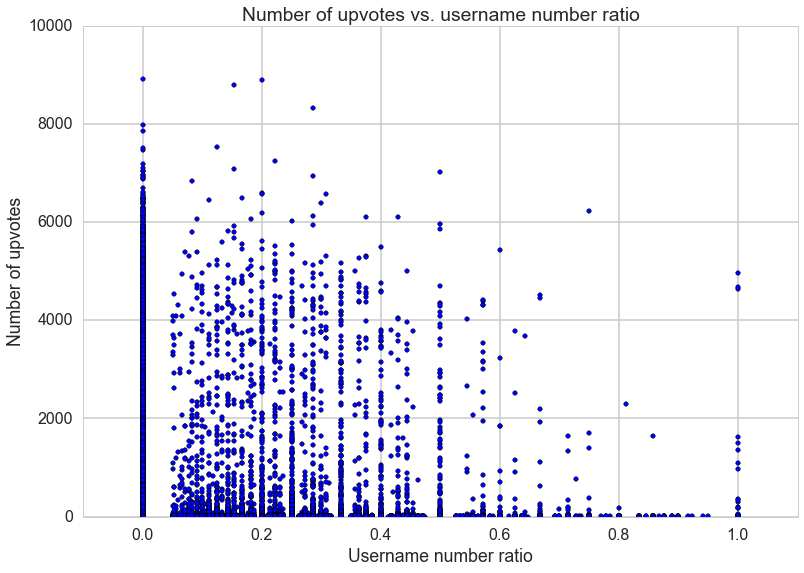

In [15]:
plt.scatter(df['un_number'], df['ups'])
plt.ylim([-0.5, 10000])
plt.xlim([-0.1, 1.1])
plt.title('Number of upvotes vs. username number ratio')
plt.xlabel('Username number ratio')
plt.ylabel('Number of upvotes')

From the above, there does not seem to be a relationship between upvotes and username number ratio. It is clear, thought, that most authors do not have numbers in their username. 

In [16]:
print "Special username averages:"
print "________________________________"
print "# of usernames with PM_(x):", len(df[df['un_PM'] == 1])
print "Average # of upvotes:", float(sum(df[df['un_PM'] == 1].ups))/float(len(df[df['un_PM'] == 1]))
print "________________________________"
print "# of usernames w/o PM_(x):", len(df[df['un_PM'] == 0])
print "Average # of upvotes:", float(sum(df[df['un_PM'] == 0].ups))/float(len(df[df['un_PM'] == 0]))
print "________________________________"
print "# of usernames with bot:", len(df[df['un_bot'] == 1])
print "Average # of upvotes:", float(sum(df[df['un_bot'] == 1].ups))/float(len(df[df['un_bot'] == 1]))
print "________________________________"
print "# of usernames w/o bot:", len(df[df['un_bot'] == 0])
print "Average # of upvotes:", float(sum(df[df['un_bot'] == 0].ups))/float(len(df[df['un_bot'] == 0]))

Special username averages:
________________________________
# of usernames with PM_(x): 279
Average # of upvotes: 140.913978495
________________________________
# of usernames w/o PM_(x): 164394
Average # of upvotes: 80.7745720647
________________________________
# of usernames with bot: 448
Average # of upvotes: 64.6830357143
________________________________
# of usernames w/o bot: 164225
Average # of upvotes: 80.9206393667


There are not many "PM_(x)" usernames, but those with this username have double the baseline average number of upvotes. However, if the username contains "bot," the user gets significantly fewer than average number of upvotes.

###Sentiment Analysis

Another feature that we incorporate is sentiment analysis: is the comment positive or negative, and are there more upvotes if the question has a similar ratio?

We can thus calculate two features:
1. How positive/negative the comment is
2. Positive/negative ratio to the question

Instead of doing Naive Bayes or LDA like in HW 5, we took the suggested route in HW5: SentiWordNet for Python. First, we need to import NLTK: Natural Language ToolKit.

In [18]:
import nltk
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

We then use ```senti_classifier```, which uses SentiWordNet, an external sentiment annotated corpus. The inner workings of ```senti_classifier``` are similar to the Naive Bayes process we did in HW5. 

```senti_classifier``` has a method called ```polarity_scores```, which gives a positive and negative polarity score  based on the comment's body content. For feature (1), we simply take ```C = pos_score - neg_score``` for a column ```pos_neg_score```. 

In [ ]:
from senti_classifier import senti_classifier

def pos_neg_score (text):
    pos_score, neg_score = senti_classifier.polarity_scores([text])
    return pos_score - neg_score

df['pos_neg_score'] = df['body'].map(lambda x : pos_neg_score(x))

We then incorporate the question's polarity score (```Q```) for feature (2), where we have ```C/Q``` to get the column ```question_pos_neg```. If ```Q=0```, then we let the ratio = 0. 

In [ ]:
question_pos_neg = []
for index, row in df.iterrows():
    pos_score, neg_score = senti_classifier.polarity_scores([row._submission.title])
    q_pos_neg = pos_score - neg_score
    value = 0 if q_pos_neg == 0 else row.pos_neg_score/q_pos_neg
    question_pos_neg.append(value)

df['question_pos_neg'] = question_pos_neg